# Explore other structural (DWI) measures

In [3]:
%cd work/notebooks

# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");

/home/jovyan/work/notebooks


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [4]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')

# dme_ds8 = gradientVersion().fit('hcp_ds8')
# dme_ds5 = gradientVersion().fit('hcp_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
hcp_scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/hcp_3d_ds5_spin_5000_v2.npy")
# null_scores = np.load("../outputs/permutations/hcp_ds8_spin_5000.npy")

# hcp_scores = pd.concat({
#     'DS5':dme_ds5.clean_scores(),
#     'DS8':dme_ds8.clean_scores(),
#     '3donors DS5':dme_3d_ds5.clean_scores()
# }).reset_index(0).rename({'level_0':'version'},axis=1)

## structural metrics

matrices from Karahan 2022

In [11]:
from scipy.io import loadmat
data = loadmat("../data/karahan2022_SC_micro.mat")
data
# meg_names = [x[0] for x in meg_data['FrequenciesStr'][0]]
# meg_mats = meg_data['A'][0][0][0][0]
# meg = dict(zip(meg_names, meg_mats))

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Aug  4 23:40:37 2022',
 '__version__': '1.0',
 '__globals__': [],
 'SC_micro': array([[array([[[        nan,         nan,         nan, ...,         nan,
                          nan,         nan],
                 [        nan,         nan,         nan, ...,         nan,
                          nan,         nan],
                 [        nan,         nan,         nan, ...,         nan,
                          nan,         nan],
                 ...,
                 [ 2.84999331,         nan,         nan, ...,         nan,
                          nan,  2.81015115],
                 [        nan,         nan,         nan, ...,         nan,
                          nan,         nan],
                 [        nan,         nan,         nan, ...,         nan,
                          nan,         nan]],
 
                [[        nan,         nan,         nan, ...,         nan,
                          nan,

In [17]:
data['metrics']

array([[array(['FA'], dtype='<U2'), array(['MD'], dtype='<U2'),
        array(['ODI'], dtype='<U3'), array(['ICVF'], dtype='<U4'),
        array(['RD'], dtype='<U2'), array(['AD'], dtype='<U2'),
        array(['FR'], dtype='<U2')]], dtype=object)

In [22]:
data['mSC_metrics']

(664, 664, 51, 7)

Sum to get connectivity

In [131]:
meg_connectivity = pd.DataFrame({name:mat.sum(1) for name,mat in meg.items()})
meg_connectivity.shape

(230, 4)

ROI labels don't perfectly match so extract list of matching labels

In [138]:
mapping = loadmat("../data/parcellations/karahan2022_HCP_atlas_sampling.mat")
retained_labels = np.hstack(np.char.split(np.hstack(mapping['ROIlabels'].flatten()), sep=' + '))
meglabels = pd.Series(retained_labels).str.extract('_(.*)_')[0].replace({'7PL':'7Pl'}).rename(None)
np.setdiff1d(get_labels_hcp(), meglabels)

array(['H'], dtype=object)

Use mapping matrix to convert to original HCP parcellation and rename with matching labels

In [152]:
meg_connectivity_hcp = ((mapping['reg_meg2dwi'] @ meg_connectivity)
                        .set_axis(meglabels).iloc[:179].reindex(get_labels_hcp()[:180])
                        .apply(lambda x: (x-np.mean(x))/np.std(x))
)

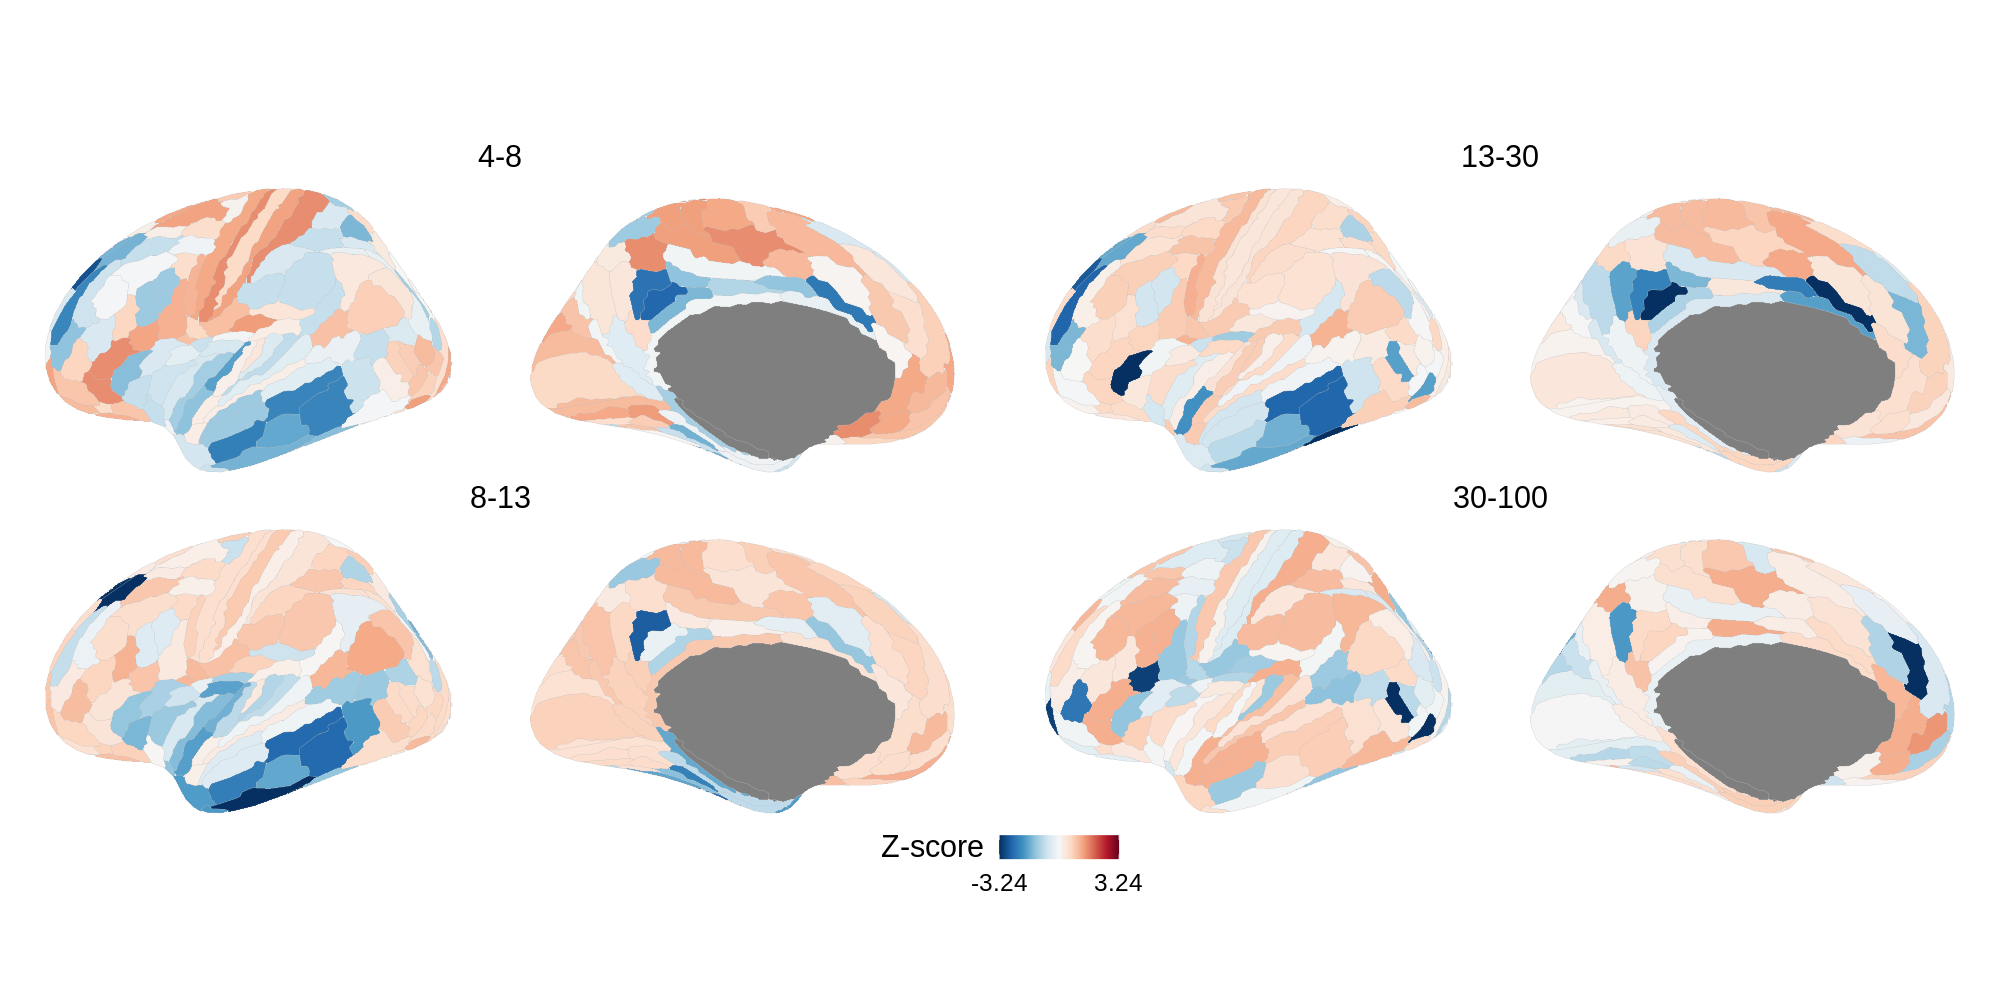

In [153]:
%%R -i meg_connectivity_hcp -w 20 -h 10 -u in -r 100
source("../code/plot_maps.R")
plot_maps(meg_connectivity_hcp)

## Baum

In [36]:
baum_t1t2 = pd.DataFrame({
    '8to10': nib.load("../data/baum_mean_young_T1wT2w_8to10.pscalar.nii").get_fdata().squeeze(),
    '14to16': nib.load("../data/baum_mean_mid_T1wT2w_14to16.pscalar.nii").get_fdata().squeeze(),
    '19to21': nib.load("../data/baum_mean_old_T1wT2w_19to21.pscalar.nii").get_fdata().squeeze()
}, index=get_labels_hcp()).iloc[:180,:]

In [41]:
baum_t1t2 = (baum_t1t2
             .assign(delta = lambda x: x['19to21']-x['14to16'])
             .apply(lambda x: (x-np.mean(x))/np.std(x))
)

In [46]:
baum_t1t2.join(hcp_scores.set_index('label')).corr()

,8to10,14to16,19to21,delta,G1,G2,G3
8to10,1.000000,0.977855,0.959893,-0.158014,7.721380e-01,1.466484e-01,4.132201e-01
14to16,0.977855,1.000000,0.993539,-0.056835,8.151205e-01,6.109350e-02,3.771397e-01
19to21,0.959893,0.993539,1.000000,0.056835,8.114116e-01,6.366793e-02,3.596176e-01
delta,-0.158014,-0.056835,0.056835,1.000000,1.736044e-02,2.947776e-02,-1.481025e-01
G1,0.772138,0.815120,0.811412,0.017360,1.000000e+00,-8.104563e-07,4.427731e-07
G2,0.146648,0.061094,0.063668,0.029478,-8.104563e-07,1.000000e+00,-1.204146e-08
G3,0.413220,0.377140,0.359618,-0.148103,4.427731e-07,-1.204146e-08,1.000000e+00


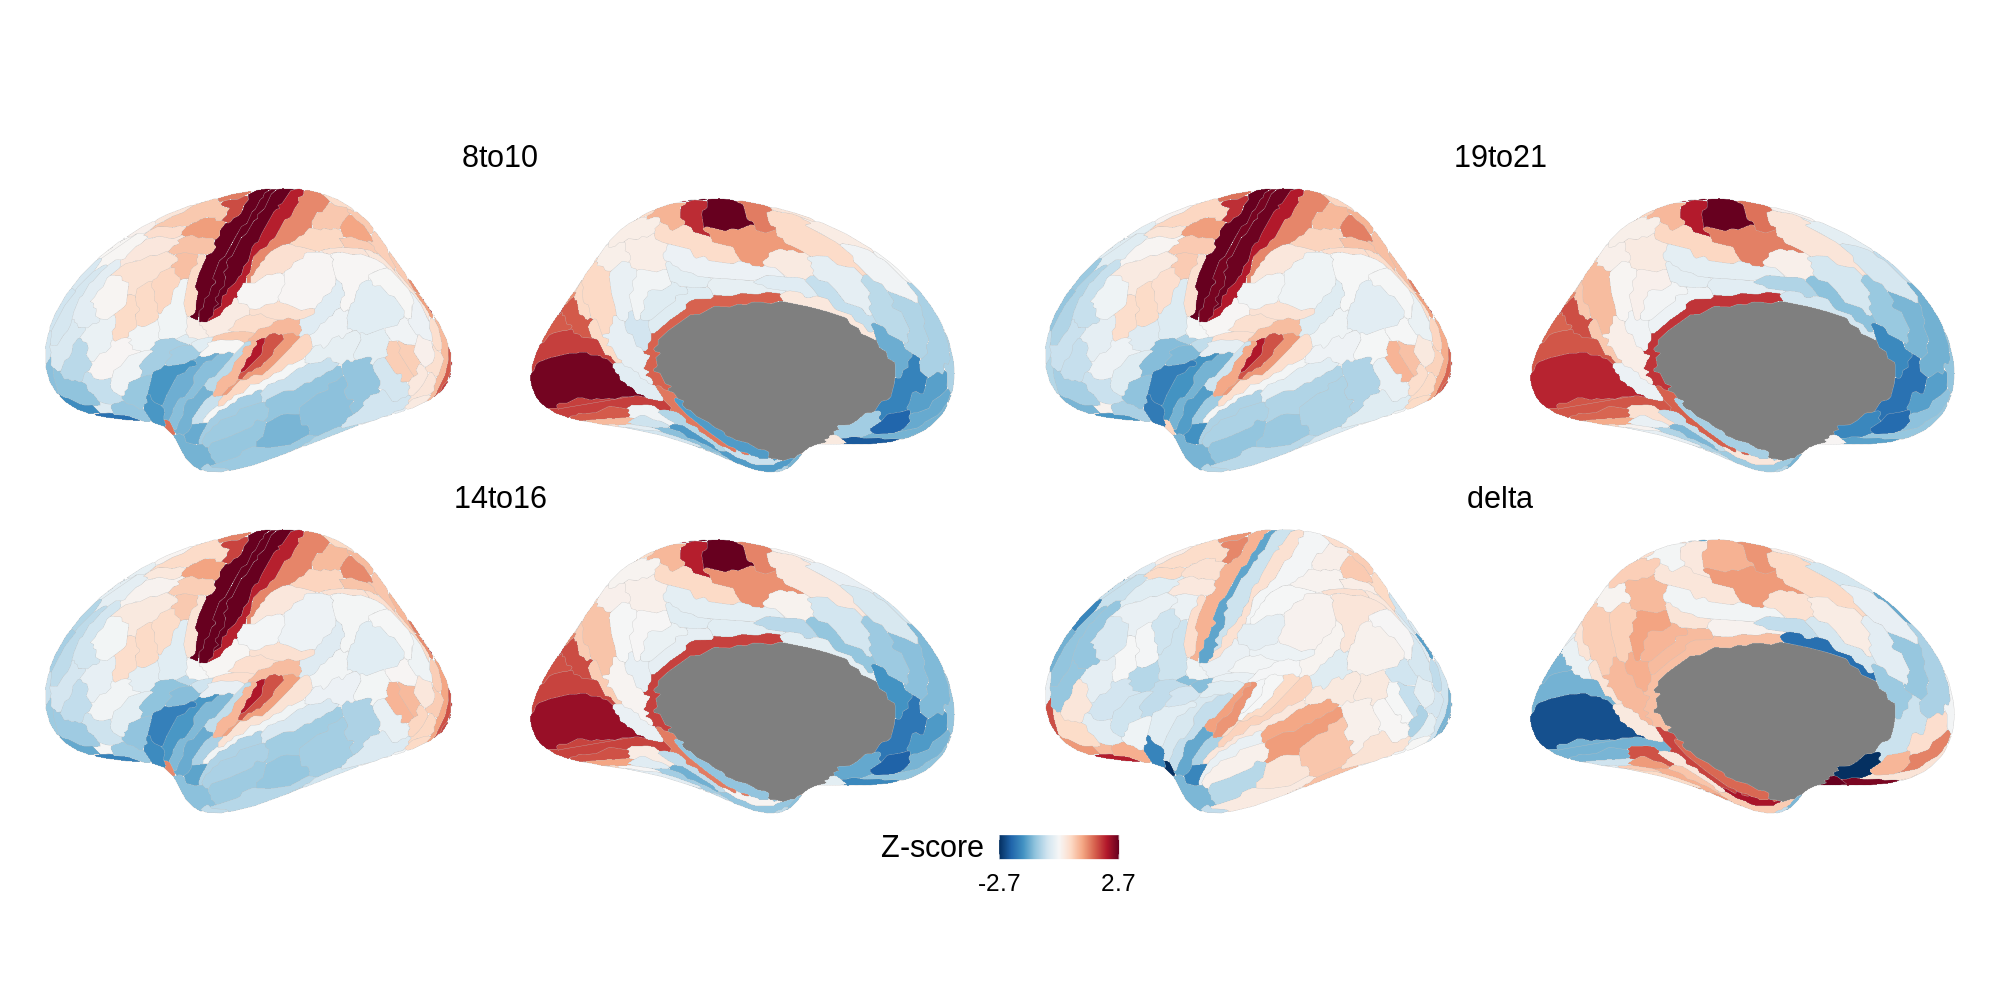

In [42]:
%%R -i baum_t1t2 -w 20 -h 10 -u in -r 100
source("../code/plot_maps.R")
plot_maps(baum_t1t2)